# 🛳️ Titanic Survival Prediction

## Importing Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [46]:
np.random.seed(42)

## Reading the data

In [111]:
df = pd.read_csv('./data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [49]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


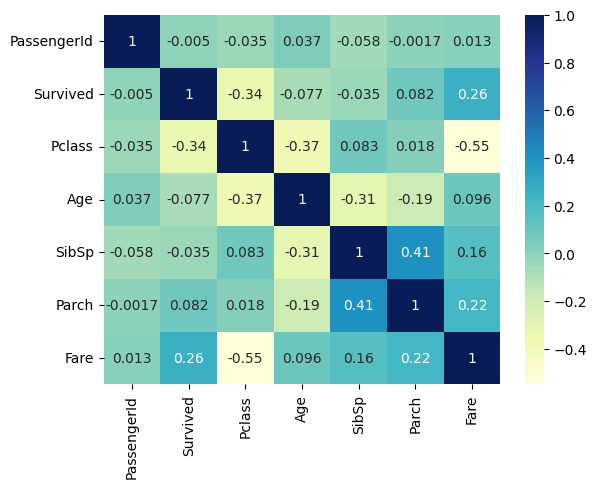

In [50]:
sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True);

## Data Preprocessing

In [51]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [147]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')

    def fit(self, X, y=None):
        self.imputer.fit(X[['Age']])
        return self

    def transform(self, X):
        X = X.copy()
        X['Age'] = self.imputer.transform(X[['Age']])
        return X

In [155]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = None
        self.categorical_features = ['Embarked', 'Sex']

    def fit(self, X, y=None):
        self.encoder = ColumnTransformer(transformers=[
            ("onehot", OneHotEncoder(handle_unknown="ignore"), self.categorical_features),
        ])
        self.encoder.fit(X)
        return self

    def transform(self, X):
        X = X.copy()
        encoded = self.encoder.transform(X)
        encoded_cols = self.encoder.named_transformers_["onehot"].get_feature_names_out(self.categorical_features)
        encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=X.index)
        X = X.drop(columns=self.categorical_features)
        return pd.concat([X, encoded_df], axis=1)

In [149]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop or ['Embarked', 'Sex', 'Name', 'Cabin', 'N', 'Ticket']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')

In [151]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X):
        scaled = self.scaler.transform(X)
        return pd.DataFrame(scaled, columns=X.columns, index=X.index)

In [156]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('age_imputer', AgeImputer()),
    ('feature_encoder', FeatureEncoder()),
    ('feature_droper', FeatureDropper()),
    ('feature_scaler', FeatureScaler()),
])

In [167]:
df = pd.read_csv('./data/train.csv')

## Split into Train and Test set

In [172]:
X = df.drop('Survived', axis=1)
X = pipeline.fit_transform(X)
y = df['Survived']

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

In [174]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [175]:
model.score(X_test, y_test)

0.8156424581005587

In [176]:
grid = {'n_estimators': [100, 200, 500],
          'max_depth': [None, 5, 10],
          'max_features': ['log2', 'sqrt'],
          'min_samples_split': [6],
          'min_samples_leaf': [1, 2]}
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator=model,
                      param_grid=grid, 
                      cv=5,
                      verbose=0)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2], 'min_samples_split': [6],
                         'n_estimators': [100, 200, 500]})

In [177]:
gs.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 200}

In [178]:
final_clf = gs.best_estimator_

In [179]:
final_clf.score(X_test, y_test)

0.8044692737430168

## Evaluation

In [186]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [187]:
cross_val_score(final_clf, X, y, cv=5).mean()

np.float64(0.8170485217500472)

In [188]:
y_preds = final_clf.predict(X_test)

In [189]:
confusion_matrix(y_test, y_preds)

array([[92, 13],
       [22, 52]])

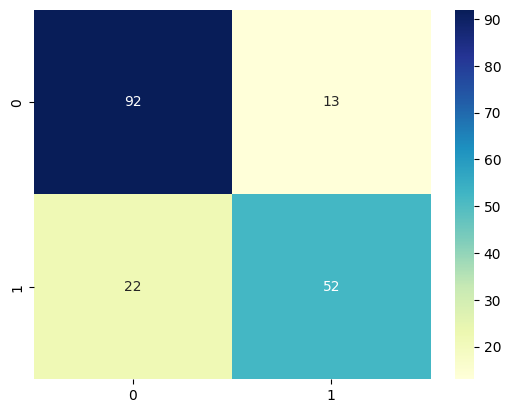

In [191]:
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap="YlGnBu");

In [192]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [193]:
clf = final_clf
y_probs = clf.predict_proba(X_test)

In [194]:
y_probs_positive = y_probs[:,1]

In [195]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)

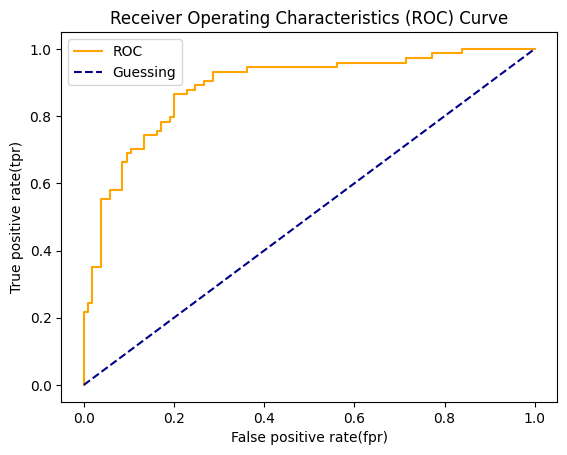

In [196]:
def plot_roc(fpr, tpr):
    """
    Plots a ROC curve given the false positive rate(fpr) and true positive rate(tpr)
    """

    # Plot ROC curve
    plt.plot(fpr, tpr, color='orange', label='ROC')
    
    # Plot line with no predictive power(baseline)
    plt.plot([0,1], [0,1], color='darkblue', linestyle='--', label='Guessing')

    # Customize plot
    plt.xlabel('False positive rate(fpr)')
    plt.ylabel('True positive rate(tpr)')
    plt.title('Receiver Operating Characteristics (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc(fpr,tpr)

In [197]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_probs_positive)

np.float64(0.8875160875160876)